### Getting started

In [17]:
import matplotlib.pyplot as plt
import numpy as np

import maria 

In order to construct a model, we need some ingredients.

The first ingredient is the array, which entirely defines the telescope. The Array object contains all the information about detector offsets, baselines, frequencies, and more, as well as apertures and observational constraints on the instrument.

We can load one of `maria`'s predefined arrays ([MUSTANG-2](https://greenbankobservatory.org/science/gbt-observers/mustang-2/)) 

In [18]:
m2 = maria.get_array("MUSTANG-2")
m2.description

''

and plot the detector offsets:

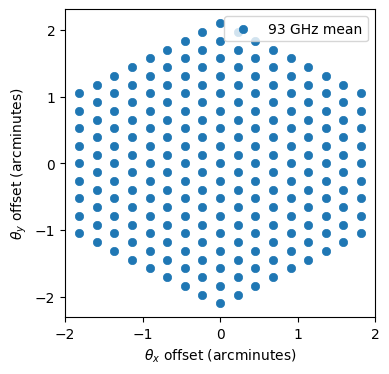

In [19]:


plt.figure(figsize=(4, 4))

for uband in m2.ubands:

    band_mask = m2.band == uband

    plt.scatter(60 * np.degrees(m2.offset_x[band_mask]), 
                60 * np.degrees(m2.offset_y[band_mask]),
                label=f'{int(uband[1:])} GHz mean', lw=5e-1)

plt.xlabel(r'$\theta_x$ offset (arcminutes)')
plt.ylabel(r'$\theta_y$ offset (arcminutes)')
plt.legend()

The second ingredient is the pointing, which determines where and how the telescope moves, and how fast it samples. 

We can loading a default scan with a two-degree radius from `maria`:

In [20]:
daisy_scan = maria.get_pointing("DAISY_2deg_4ra_10dec_600s")
daisy_scan.description

''

Text(0, 0.5, 'Dec. (degrees)')

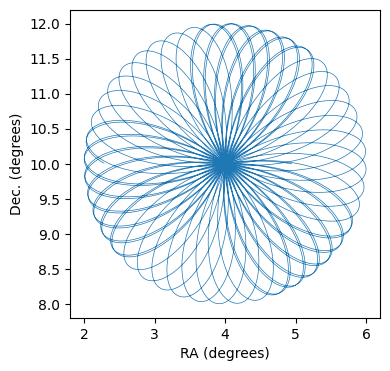

In [21]:
plt.figure(figsize=(4,4))

plt.plot(np.degrees(daisy_scan.ra), 
         np.degrees(daisy_scan.dec),
         lw=5e-1)

plt.xlabel(r'RA (degrees)')
plt.ylabel(r'Dec. (degrees)')

The last ingredient is the site, which determines the translation between local coordinates and sky coordinates. It also determines the weather parameters that go into the atmospheric simulation. 

Loading the Green Bank Telescope site from `maria`:

In [22]:
green_bank = maria.get_site("GBT")
green_bank.description

'Green Bank Telescope'

We can combine these objects by passing them to one of `maria`'s models. On construction, the simulation is initialized:

In [23]:
sim = maria.Simulation(array=m2, pointing=daisy_scan, site=green_bank)

Computing weights: 100%|██████████| 4/4 [00:00<00:00, 145.86it/s]


This also computes things which depend on multiple inputs ()



Text(0, 0.5, 'elevation (degrees)')

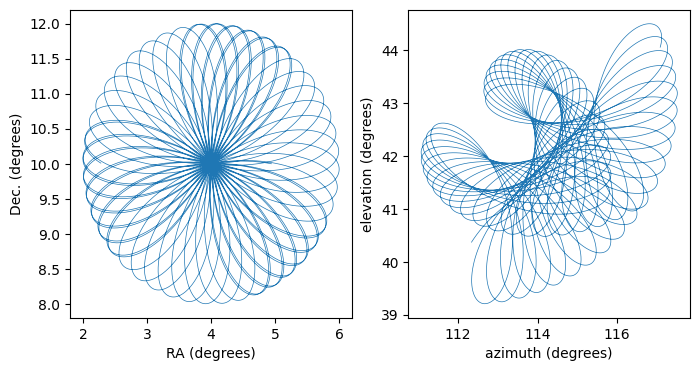

In [24]:
fig, axes = plt.subplots(1,2,figsize=(8,4))

axes[0].plot(np.degrees(sim.pointing.ra), 
             np.degrees(sim.pointing.dec),
             lw=5e-1)

axes[0].set_xlabel(r'RA (degrees)')
axes[0].set_ylabel(r'Dec. (degrees)')

axes[1].plot(np.degrees(sim.pointing.az), 
             np.degrees(sim.pointing.el),
             lw=5e-1)

axes[1].set_xlabel(r'azimuth (degrees)')
axes[1].set_ylabel(r'elevation (degrees)')

In [30]:
tod = sim.run()

Sampling layers: 100%|██████████| 4/4 [00:01<00:00,  3.88it/s]


The simulated time-ordered data is stored `lam.temperature`, which has shape `(n_freqs, n_dets, n_samples)`. Plotting the output as fluctuations:

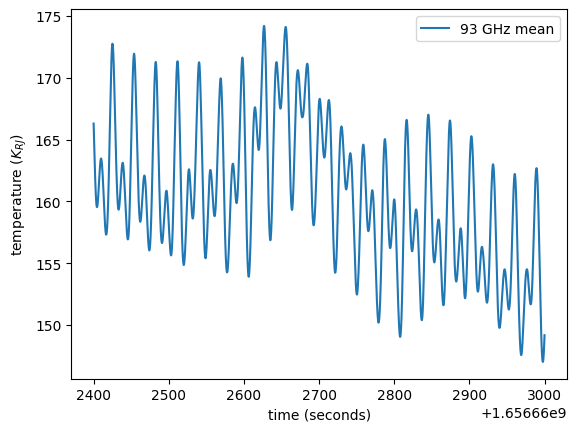

In [32]:
for uib, uband in enumerate(np.unique(tod.detectors.band)):

    band_mask = tod.detectors.band == uband
    band_mean = tod.data[band_mask].mean(axis=0)
    plt.plot(tod.time, band_mean, label=f'{int(uband[1:])} GHz mean')

plt.xlabel('time (seconds)')
plt.ylabel(r'temperature ($K_{RJ}$)')
plt.legend()